In [0]:
from fastai import *
from fastai.vision import *

In [3]:
! git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 35.94 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
path = Path('/content/SegNet-Tutorial/CamVid')

In [7]:
path.ls()

[PosixPath('/content/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test'),
 PosixPath('/content/SegNet-Tutorial/CamVid/testannot')]

In [8]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08075.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07991.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08049.png')]

In [9]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08075.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_07991.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08049.png')]

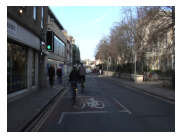

In [10]:
img = fnames[0]
img = open_image(img)
img.show(figsize=(3,3))

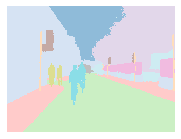

In [12]:
lbl = lbl_names[0]
lbl = open_mask(lbl)
lbl.show(figsize=(3,3))

In [0]:
def get_y_fn(x): 
  return Path(str(x.parent)+'annot')/x.name

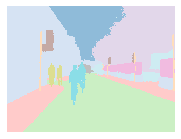

In [14]:
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(3,3))

In [16]:
mask.shape, mask.size

(torch.Size([1, 360, 480]), torch.Size([360, 480]))

In [17]:
mask.data

tensor([[[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3]]])

These codes are not given in the downloaded dataset

In [0]:
codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [0]:
bs=8

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms() , tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

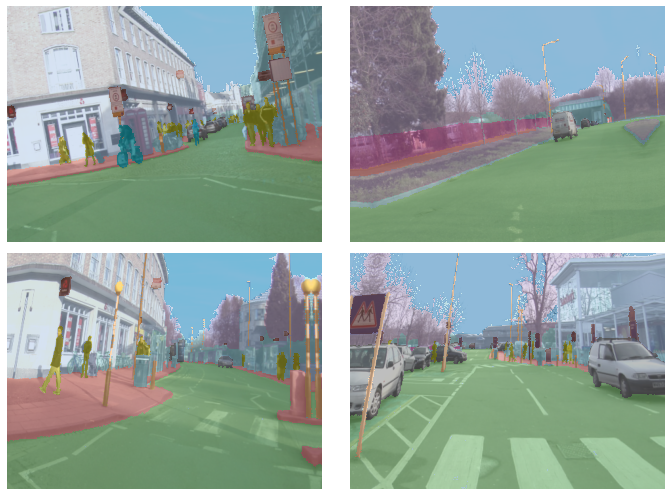

In [26]:
data.show_batch(2, figsize=(10,7))

custom accuracy function to remove void class code

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


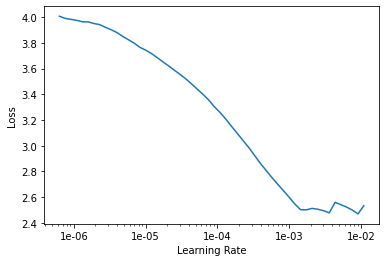

In [30]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [32]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.213604,0.819009,0.770060,00:26
1,0.810271,0.674092,0.807543,00:24
2,0.650895,0.580908,0.807520,00:24
3,0.544734,0.535801,0.848965,00:24
4,0.500754,0.474427,0.871659,00:24
5,0.947869,1.796179,0.364360,00:24
6,1.142651,0.969960,0.753077,00:24
7,0.939365,0.659164,0.807780,00:24
8,0.692932,0.526643,0.853972,00:24
9,0.546462,0.436438,0.884715,00:24


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [37]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.434926,0.428270,0.884507,00:26
1,0.421685,0.417189,0.883367,00:26
2,0.406067,0.366164,0.886032,00:26
3,0.376915,0.340153,0.888821,00:26
4,0.361695,0.345602,0.896410,00:26
5,0.368765,0.354487,0.892721,00:26
6,0.350374,0.361924,0.885293,00:26
7,0.328556,0.321645,0.911575,00:26
8,0.320137,0.307172,0.911801,00:26
9,0.305106,0.352421,0.904300,00:25


In [0]:
learn.save('stage-2');